In [1]:
import sys
sys.path.append("..")

is_in_colab = 'google.colab' in sys.modules

if is_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.insert(0,'/content/drive/MyDrive/nlp_question_answer_project')

    %cd /content/drive/MyDrive/nlp_question_answer_project/notebooks

In [2]:
%%capture
!pip install -r ../requirements.txt

# 1.2 Binary Question Classification

In [92]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer

from enum import Enum

import fasttext
import fasttext.util

import torch
from torch import nn
import torch.optim as optim

import torchnlp
import torchnlp.nn

from sklearn.metrics import accuracy_score
import compress_fasttext
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [93]:
class Annotation_error(Enum):
    UNANSWERED = -1
    BAD_TOKENIZATION_OR_DATA = -2
    IGNORED = -3
    # Or the span e.g. (4,9)

In [94]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Load pre-processed data from memory.

In [95]:
path_train_set = "../data/train_set_stanza.pkl"
path_validation_set = "../data/validation_set_stanza.pkl"

In [96]:
train_set = pd.read_pickle(path_train_set)
validation_set = pd.read_pickle(path_validation_set)

In [131]:
def extract_language(dataset, language):
    return dataset[dataset["language"] == language]

In [132]:
train_en = extract_language(train_set, "english")
train_fi = extract_language(train_set, "finnish")
train_ja = extract_language(train_set, "japanese")

validation_en = extract_language(validation_set, "english")
validation_fi = extract_language(validation_set, "finnish")
validation_ja = extract_language(validation_set, "japanese")

In [133]:
train_en

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(26, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(12, 13)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(27, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(16, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(1, 37)"
...,...,...,...,...,...
7384,english,"[What, was, Neil, Brooks, ', fastest, recorded...","[Swimming, at, the, 1980, Summer, Olympics, –,...","[The, medley, relay, was, scheduled, in, the, ...",Annotation_error.UNANSWERED
7385,english,"[Who, are, the, three, most, important, easter...","[Eastern, philosophy]","[Sāmkhya, is, a, dualist, philosophical, tradi...",Annotation_error.UNANSWERED
7386,english,"[Who, was, costume, designer, for, the, first,...","[John, Mollo]","[Mollo, was, surprised, by, the, success, of, ...",Annotation_error.UNANSWERED
7387,english,"[Who, developed, the, first, thermonuclear, we...","[History, of, nuclear, weapons]","[In, the, end, ,, President, Truman, made, the...",Annotation_error.UNANSWERED


In [99]:
OOV_token = "[OOV]"

In [100]:
def create_words_to_ids(word_lists):
    word_to_ix = {}
    for words in word_lists:
        for word in words:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
    
    if OOV_token not in word_to_ix:
        word_to_ix[OOV_token] = len(word_to_ix)
    
    return word_to_ix

In [101]:
def get_word_id(word: str, word_to_ix):
    return word_to_ix[word] if word in word_to_ix.keys() else len(word_to_ix) ## OOV token id

In [102]:
def make_bow_vector(sentence, word_to_ix):
    vec = np.zeros(len(word_to_ix))
    for word in sentence:
        if word in word_to_ix.keys():
            vec[word_to_ix[word]] += 1
        else:
            vec[word_to_ix[OOV_token]] += 1
    return vec

In [103]:
def get_bag_of_words(data_feature, word_ids):
    X = np.empty((len(data_feature), len(word_ids)))
    for i, _ in enumerate(data_feature):
        X[i] = make_bow_vector(data_feature.iloc[i], word_ids)
    return X

In [104]:
def get_lengths(data_feature):
    return np.array([len(words) for words in data_feature])

In [105]:
def count_word_overlaps(data_feature, reference_data_feature, normalize:bool = True): 
    assert(data_feature.shape[0] == reference_data_feature.shape[0])
    
    X = np.empty(data_feature.shape[0])
    for i in range(data_feature.shape[0]):
        word_ids = create_words_to_ids([reference_data_feature.iloc[i]])
        X[i] = np.sum([token in word_ids.keys() for token in data_feature.iloc[i]]) # @TODO: skip first word and last word?
        
        if normalize:
            size = len(data_feature.iloc[i])
            X[i] /= size
        
    return X

In [106]:
count_word_overlaps(train_en['question'], train_en['document'])

array([0.42857143, 0.7       , 0.57142857, ..., 0.45454545, 0.28571429,
       0.33333333])

## Feature Exploration
### Distributions over the number of words

In [107]:
def plot_document_length_dist(dataset, title):
    lengths = get_lengths(dataset['document'])

    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Number of tokens")

    ax.hist(lengths, bins=300, density=True) # let's use an histogram instead with fixed bins, since there is much variability.
    
    #ticks = np.linspace(min(uniques), max(uniques)+1, 10)
    #ax.set_xticks(ticks)

In [108]:
def plot_question_length_dist(dataset, title):
    question_lengths = get_lengths(dataset['question'])

    uniques, uniques_counts = np.unique(question_lengths, return_counts=True)
    index_sorted = np.argsort(uniques, axis=None)

    uniques_counts_percentage = uniques_counts / np.sum(uniques_counts) * 100

    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Number of tokens")

    x = uniques[index_sorted]
    ax.bar(x, uniques_counts_percentage[index_sorted])
    ticks = np.arange(min(uniques), max(uniques)+1, 1)
    ax.set_xticks(ticks)

#### English

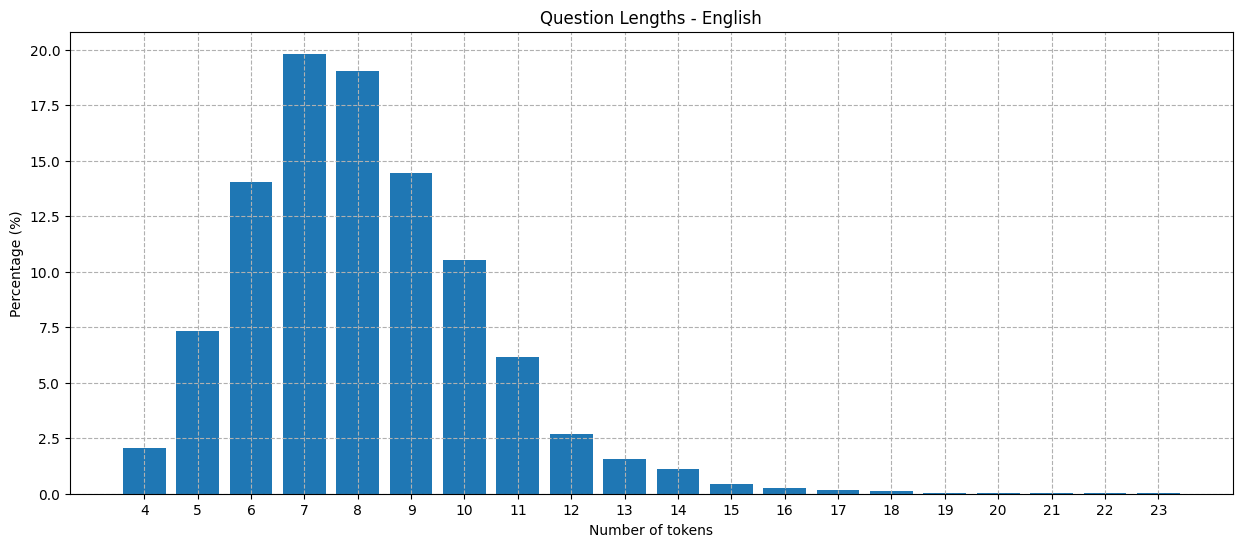

In [109]:
plot_question_length_dist(train_en, "Question Lengths - English")

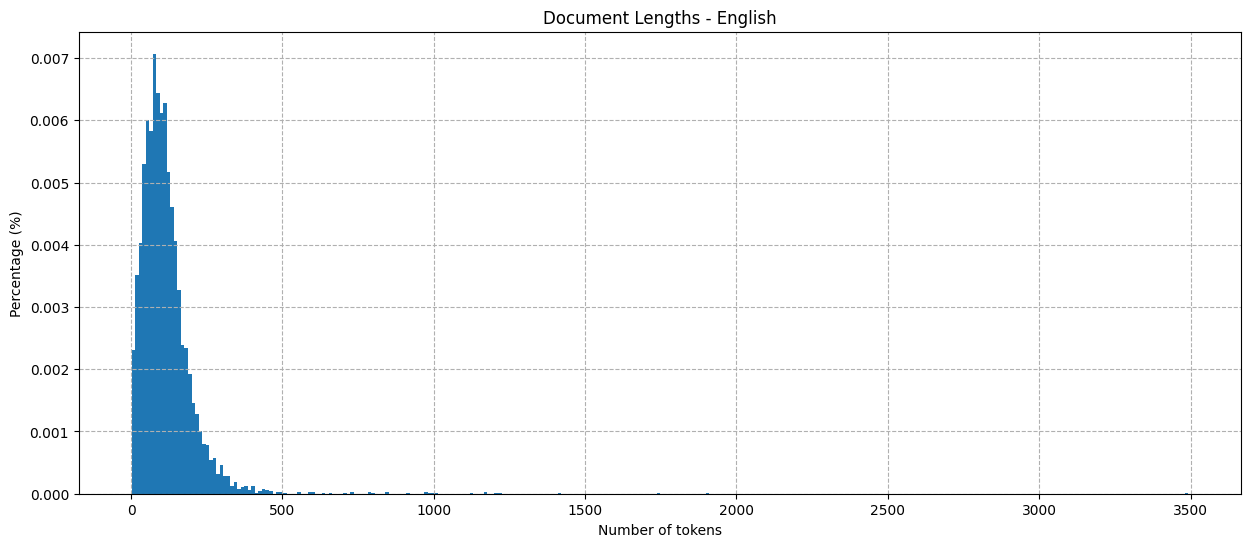

In [110]:
plot_document_length_dist(train_en, "Document Lengths - English")

#### Finnish

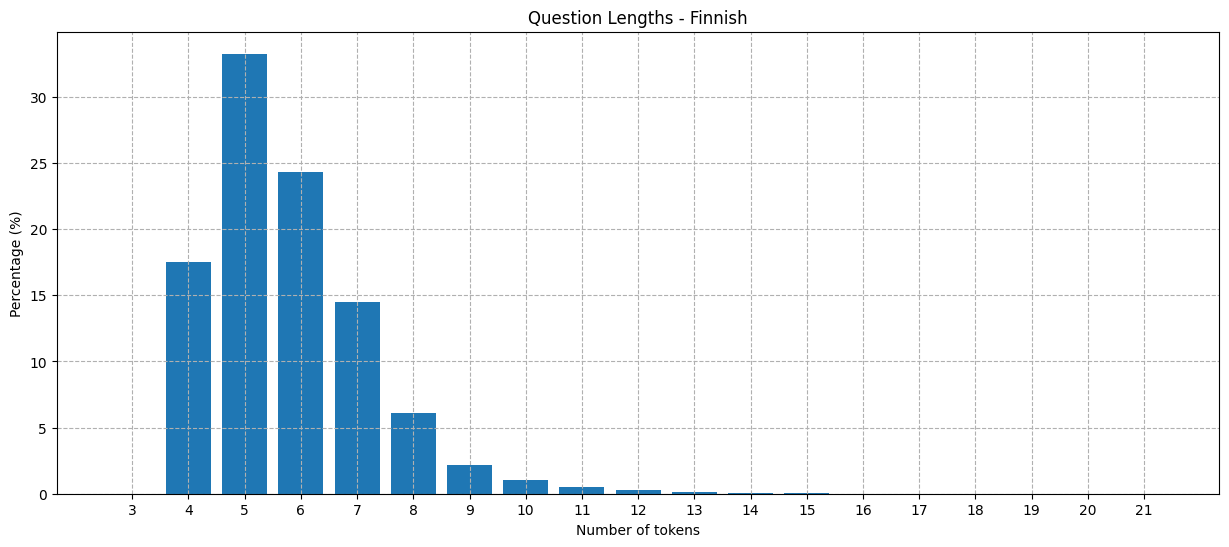

In [111]:
plot_question_length_dist(train_fi, "Question Lengths - Finnish")

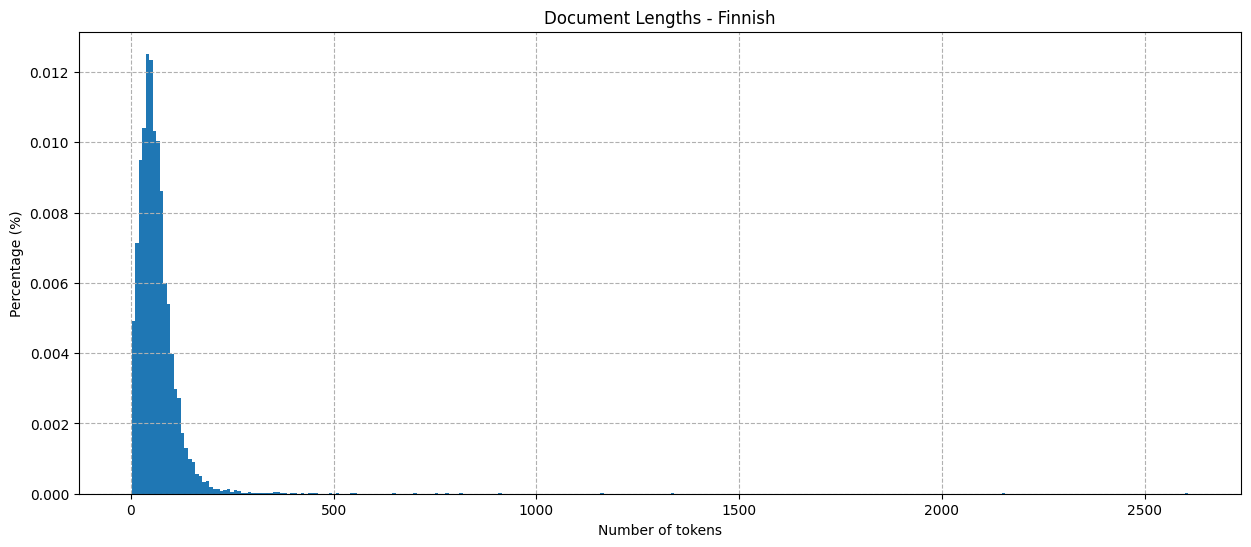

In [112]:
plot_document_length_dist(train_fi, "Document Lengths - Finnish")

#### Japenese

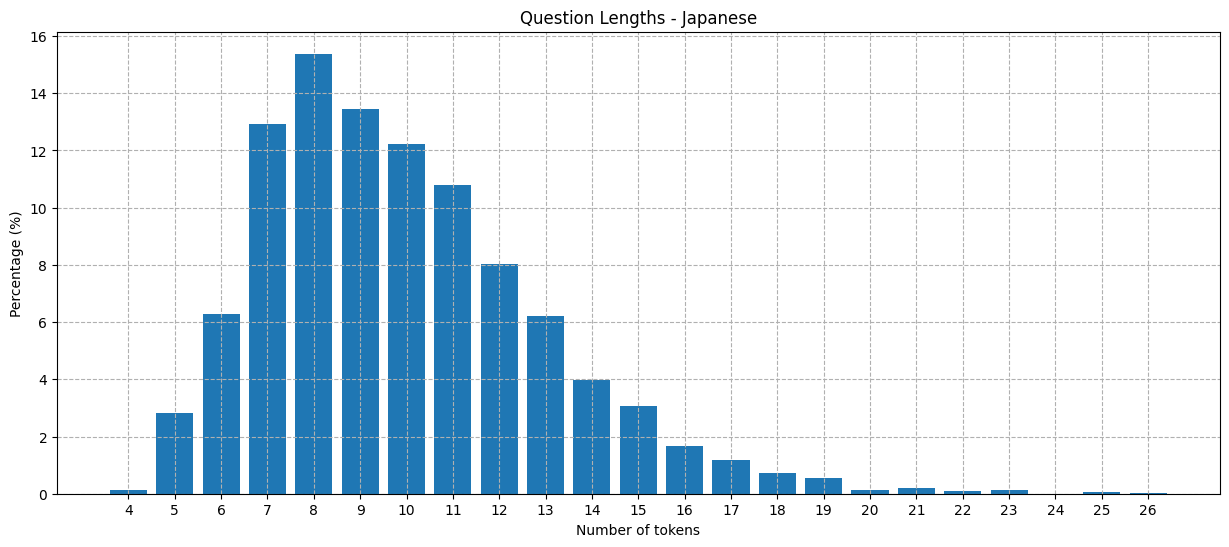

In [113]:
plot_question_length_dist(train_ja, "Question Lengths - Japanese")

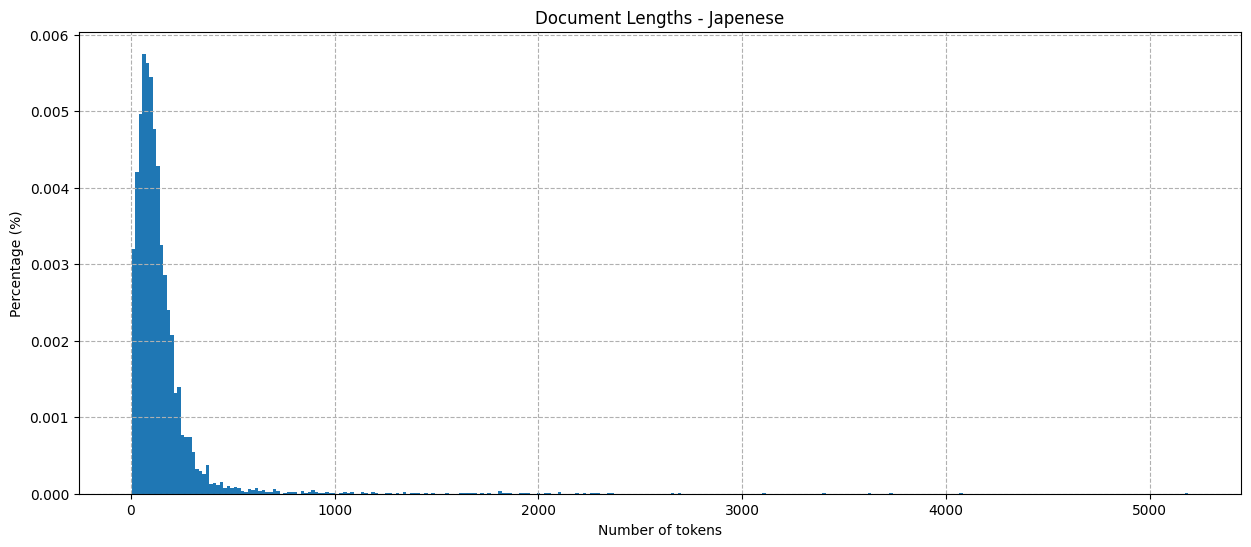

In [114]:
plot_document_length_dist(train_ja, "Document Lengths - Japenese")

### Features 

@TODO: plot distribution of whether question are answered based on the start word, "How, when, Why" etc

#### Reason
OK:
- Bag of Words for Question tokens (some words are easier to answer, e.g. When vs How) (also with TF-IDF extension. however, no noticeable change! Actually a bit worse accuracy)
- Number of tokens in document (A longer document is more likely to have the correct answer than a short document)
- Number of tokens in question (A longer answer looks for a very specific answer)
- (Proposed in project description) Answer overlap between document and text
-----------------
Ignored:
- BoW for the document was not included as part of the features as 1. the memory was on exhausted both on a local machine and cloud machine. 2. BoW is likely a poor feature for question-answer classifiction problems, since this problem needs sentence context, in order to determine whether the question has been answered or not.

--------------------
#### Memory getting exhausted

In [115]:
# @Note: Too slow. This corresponds to the overlap between the two features and taking into account which words overlap
# A simpler version is to give a single numeric value for the fractions of words overlapping.
def get_bag_of_words_overlaps(data_feature_1, data_feature_2, word_ids):
    bow_1 = get_bag_of_words(data_feature_1, word_ids)
    bow_2 = get_bag_of_words(data_feature_2, word_ids)
    return bow_1 * bow_2

In [116]:
#word_ids_all = create_words_to_ids(pd.concat([train_en['question'], train_en['document'], validation_en['question'], validation_en['document']]))
#print("{} unique words".format(len(word_ids_all)))

-----------------------


## Q1.2a

In [117]:
def get_X(dataset, training_word_ids):
    q_bow = get_bag_of_words(dataset['question'], training_word_ids) # @Note: tokens not in the training dataset, meaning some tokens for the validation dataset, are not in this BOW vector.
    document_lengths = get_lengths(dataset['document']).reshape((-1,1))
    question_lengths = get_lengths(dataset['question']).reshape((-1,1))
    word_overlap = count_word_overlaps(dataset['question'], dataset['document']).reshape((-1,1))

    vectorizer = TfidfTransformer()
    q_tf_idf = vectorizer.fit_transform(q_bow).toarray() # BoW -> TF-IDF

    X = np.concatenate((q_tf_idf, document_lengths, question_lengths, word_overlap), axis=1)

    return X

In [118]:
# If the question is answered, then predict "1". Otherwise predict "0".
def get_target(dataset):
    answer_set = dataset['document_answer_region']
    y = np.empty(answer_set.shape[0], dtype=np.int32)

    for i, answer in enumerate(answer_set):
        if type(answer) == Annotation_error and answer == Annotation_error.UNANSWERED: # @TODO: if we don't do the annotation stuff, then we can check for -1 here
            y[i] = 0
        else:
            y[i] = 1
    return y

In [119]:
def str_target_summary(y):
    num_answered = np.sum(y == 1)
    num_unanswered = np.sum(y == 0)
    return "Questions answered: {}, unanswered: {}.".format(num_answered, num_unanswered)

## Q1.2b+c

In [120]:
def evaluate(y_pred, y_true):
    report = classification_report(y_true, y_pred)
    print(report)
    
    cm = confusion_matrix(y_true, y_pred) / len(y_pred) # normalize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

In [121]:
def run_model(model, train, validation):
    word_ids = create_words_to_ids(pd.concat([train['question']])) # , validation['question']
    print("{} unique words".format(len(word_ids)))
    
    X_train = get_X(train, word_ids)
    y_train = get_target(train)

    X_validation = get_X(validation, word_ids)
    y_validation = get_target(validation)

    print("train: " + str_target_summary(y_train))
    print("validation: " + str_target_summary(y_validation))

    model.fit(X_train, y_train)
    
    preds = model.predict(X_validation)
    
    evaluate(preds, y_validation)
    
    #return preds, y_validation
    

## English

Let's do prediction on the validation set for each language and compute the accuracy.

5046 unique words
train: Questions answered: 3696, unanswered: 3693.
validation: Questions answered: 495, unanswered: 495.
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       495
           1       0.71      0.73      0.72       495

    accuracy                           0.72       990
   macro avg       0.72      0.72      0.72       990
weighted avg       0.72      0.72      0.72       990



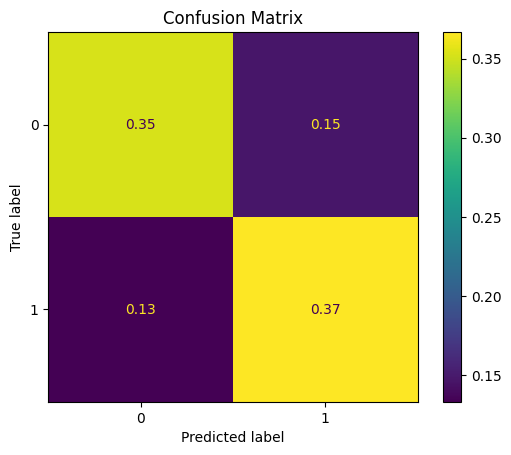

In [122]:
model_en = RandomForestClassifier()
run_model(model_en, train_en, validation_en) 

## Finnish

9941 unique words
train: Questions answered: 6855, unanswered: 6846.
validation: Questions answered: 843, unanswered: 843.
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       843
           1       0.77      0.67      0.71       843

    accuracy                           0.73      1686
   macro avg       0.74      0.73      0.73      1686
weighted avg       0.74      0.73      0.73      1686



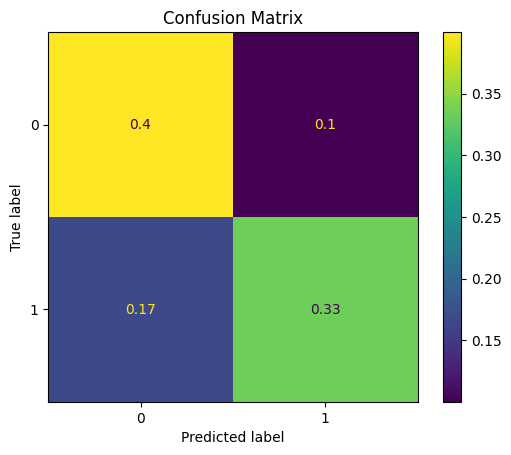

In [126]:
model_fi = RandomForestClassifier()
run_model(model_fi, train_fi, validation_fi)

## Japanese

6100 unique words
train: Questions answered: 4389, unanswered: 4389.
validation: Questions answered: 518, unanswered: 518.
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       518
           1       0.67      0.67      0.67       518

    accuracy                           0.67      1036
   macro avg       0.67      0.67      0.67      1036
weighted avg       0.67      0.67      0.67      1036



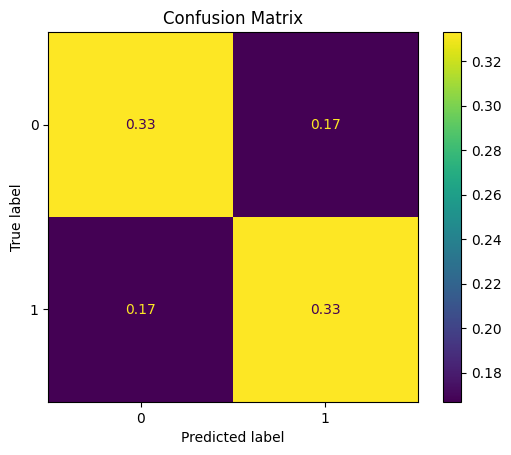

In [127]:
model_ja = RandomForestClassifier()
run_model(model_ja, train_ja, validation_ja)

# 2. Representation Learning

In [ ]:
def token_to_id(token, tok2vec):
    assert OOV_id != None

    try:
        id = tok2vec.get_index(token)
    except:
        id = OOV_id # OOV
    return id

In [ ]:
def prepare_sample(question_tokens, document_tokens, tok2vec, question_max_length=512, document_max_length=1024):
    question_ids = [token_to_id(token, tok2vec) for token in question_tokens[:question_max_length]]
    document_ids = [token_to_id(token, tok2vec) for token in document_tokens[:document_max_length]]
    return question_ids, len(question_ids), document_ids, len(document_ids)

In [61]:
def pad_tokens(token_ids, token_lengths): # in a batch
    assert pad_id != None
    
    max_length = max(token_lengths)
    padded_ids = [(ids + [pad_id] * (max_length - len(ids))) for ids in token_ids]
    
    assert (all(len(padded) == max_length for padded in padded_ids))
    
    return padded_ids

def collate_into_batch(raw_batch):
    print(raw_batch)
    question_tokens = [sample[0] for sample in raw_batch]
    question_lengths = [sample[1] for sample in raw_batch]
    question_ids = pad_tokens(question_tokens, question_lengths)
    
    document_tokens = [sample[2] for sample in raw_batch]
    document_lengths = [sample[3] for sample in raw_batch]
    document_ids = pad_tokens(document_tokens, document_lengths)
    
    targets = [sample[4] for sample in raw_batch]

    return torch.tensor(question_ids), torch.tensor(question_lengths, dtype=torch.long), torch.tensor(document_ids), torch.tensor(document_lengths, dtype=torch.long), torch.tensor(targets, dtype=torch.long)

## Q2A

## Q2b

In [125]:
class QuestionAnsweredDataset(Dataset):
    
    def __init__(self, df, tok2vec):
        self.df = df
        self.tok2vec = tok2vec
        self.targets = get_target(df)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.values[idx]
        question_tokens = row[1]
        document_tokens = row[3]
        target = self.targets[idx]
        
        question_ids, question_lengths, document_ids, document_lengths = prepare_sample(question_tokens, document_tokens, self.tok2vec)
        
        return question_ids, question_lengths, document_ids, document_lengths, target

In [37]:
class LSTM_Network(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(LSTM_Network, self).__init__()
        
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, batch_first=True)
        self.linear = nn.Linear(2*lstm_dim, 72)
        self.relu = nn.ReLU()
        self.linear_out = nn.Linear(72, n_classes)

    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.word_embeddings(q_ids)
        lstm_out, _ = self.lstm(q_embeds)
        #q_ff_in = torch.max(lstm_out, 1)[0]
        q_ff_in = lstm_out[range(lstm_out.shape[0]), (q_lengths-1).long(), :] # last unit
        
        d_embeds = self.word_embeddings(d_ids)
        lstm_out, _ = self.lstm(d_embeds)
        d_ff_in = torch.max(lstm_out, 1)[0]
        
        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        
        x = self.linear(ff_in)
        x = self.relu(x)
        logits = self.linear_out(x)

        return logits


In [38]:
class BiLSTM_Network(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(BiLSTM_Network, self).__init__()

        self.lstm_dim = lstm_dim
        self.n_classes = n_classes
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1)
        self.biLSTM = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, 1, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2*2*lstm_dim, n_classes)
        
    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.embedding(q_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(q_embeds, q_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        q_ff_in = torch.max(lstm_out, 1)[0]

        d_embeds = self.embedding(d_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(d_embeds, d_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        d_ff_in = torch.max(lstm_out, 1)[0]

        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        logits = self.linear(ff_in)
        
        return logits

In [39]:
class Attentive_LSTM_Network(nn.Module):

    # @TODO Bi!
    def __init__(self, pretrained_embeddings: torch.tensor, n_classes: int = 2):
        super(Attentive_LSTM_Network, self).__init__()

        self.lstm_and_attention_dim = pretrained_embeddings.shape[1]
        self.n_classes = n_classes

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1)
        self.q_biLSTM = nn.LSTM(pretrained_embeddings.shape[1], self.lstm_and_attention_dim, 1, batch_first=True, bidirectional=False)
        self.doc_biLSTM = nn.LSTM(pretrained_embeddings.shape[1], self.lstm_and_attention_dim, 1, batch_first=True, bidirectional=False)
        self.doc_attention = torchnlp.nn.Attention(self.lstm_and_attention_dim)
        self.linear = nn.Linear(2*self.lstm_and_attention_dim, n_classes)
        
    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.embedding(q_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(q_embeds, q_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.q_biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        #q_ff_in = torch.max(lstm_out, 1)[0] # hidden unit with max value
        q_ff_in = lstm_out[range(lstm_out.shape[0]), (q_lengths-1).long(), :] # last unit

        d_embeds = self.embedding(d_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(d_embeds, d_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.doc_biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        d_ff_in, weights = self.doc_attention(q_ff_in[:, None, :], lstm_out)
        d_ff_in = d_ff_in[:,0,:] # only 1 query so extract that

        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        logits = self.linear(ff_in)
        
        return logits

In [40]:
def prepare_embedding_matrix(embed_matrix):
    embed_dim = embed_matrix.shape[1]
    pad = torch.zeros(embed_dim, dtype=torch.float32)
    OOV = torch.zeros(embed_dim, dtype=torch.float32)
    embed_pre = torch.tensor(embed_matrix, dtype=torch.float32)
    
    OOV_id = embed_pre.shape[0]           
    pad_id = embed_pre.shape[0] + 1
                 
    return torch.vstack((embed_pre, pad, OOV)), pad_id, OOV_id

In [41]:
def test_forward_pass(model: nn.Module):
    """
    A simple function to quickly debug the net
    """
    # Test the forward pass with dummy data
    q = torch.tensor([[42, 1, 8, 0]], dtype=torch.int).to(device)
    q_lengths = torch.tensor([3], dtype=torch.int).to(device)
    d = torch.tensor([[42, 1, 8, 0]], dtype=torch.int).to(device)
    d_lengths = torch.tensor([3], dtype=torch.int).to(device)

    out = model.forward(q, q_lengths, d, d_lengths)

    print("Output shape:", out.size())
    print(f"Output logits:\n{out.cpu().detach().numpy()}")

In [42]:
def summarize_batch(q_ids, q_lengths, d_ids, d_lengths):
    assert pad_id != None

    ### question
    actual_length = torch.sum(q_lengths)
    total_length = np.sum([len(question) for question in q_ids])
    
    print("### Question ###")

    OOV_count = np.sum([torch.sum(question == OOV_id) for question in q_ids])
    print("OOV: {}/{} {:.2f}%".format(OOV_count, total_length, OOV_count / total_length * 100.))
    
    pad_count = np.sum([torch.sum(question == pad_id) for question in q_ids])
    print("PAD: {}/{} {:.2f}%".format(pad_count, total_length, pad_count / total_length * 100.))

    ## document
    actual_length = torch.sum(d_lengths)
    total_length = np.sum([len(question) for question in d_ids])
    
    print("\n### Document ###")

    OOV_count = np.sum([torch.sum(ids == OOV_id) for ids in d_ids])
    print("OOV: {}/{} {:.2f}%".format(OOV_count, total_length, OOV_count / total_length * 100.))
    
    pad_count = np.sum([torch.sum(ids == pad_id) for ids in d_ids])
    print("PAD: {}/{} {:.2f}%".format(pad_count, total_length, pad_count / total_length * 100.))   
    

In [128]:
tok2vec = compress_fasttext.models.CompressedFastTextKeyedVectors.load("../resources/fasttext-en-mini")
pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())
train_dataset = QuestionAnsweredDataset(train_en, tok2vec)

In [161]:

concatted = []
for _, l, _, _, t in train_dataset:
    a = np.array([1,2,3])
    concatted.append((a,t))

print(np.array(concatted))
#torch.tensor(concatted[])

[[array([1, 2, 3]) 1]
 [array([1, 2, 3]) 1]
 [array([1, 2, 3]) 1]
 ...
 [array([1, 2, 3]) 0]
 [array([1, 2, 3]) 0]
 [array([1, 2, 3]) 0]]


C:\ProgramData\Anaconda3\envs\nlp_qa\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [68]:
def batchify(dataset):
    """Turns a list of samples into a tensor of samples"""
    assert pad_id != None
    assert OOV_id != None

    samples = []
    for sample in dataset:
        samples.append(sample)

    return collate_into_batch(samples)

In [69]:
collated = batchify(train_dataset)
q_ids, q_lengths, d_ids, d_lengths, _ = collated

[ 0.1544919   0.15757444  0.56107866 ... 30.          7.
  0.42857143]
[0.00000000e+00 1.30804527e-01 0.00000000e+00 ... 1.88000000e+02
 1.00000000e+01 7.00000000e-01]
[  0.16326708   0.           0.         ... 112.           7.
   0.57142857]
[ 0.    0.    0.   ... 69.    4.    0.25]
[  0.    0.    0.  ... 131.    5.    0.2]
[  0.    0.    0.  ... 115.   10.    0.6]
[ 0.13406945  0.13674451  0.         ... 84.          8.
  0.625     ]
[ 0.12137986  0.          0.         ... 67.         10.
  0.5       ]
[  0.           0.           0.         ... 143.           6.
   0.33333333]
[ 0.17009096  0.17348474  0.         ... 67.          7.
  0.42857143]
[  0.           0.           0.         ... 103.           9.
   0.33333333]
[ 0.11133861  0.          0.         ... 78.         12.
  0.58333333]
[  0.           0.           0.         ... 156.           9.
   0.55555556]
[ 0.15541595  0.15851693  0.         ... 65.          9.
  0.55555556]
[ 0.   0.   0.  ... 97.  10.   0.7]
[ 0.113

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [ ]:
summarize_batch(q_ids, q_lengths, d_ids, d_lengths)

In [ ]:
def transfer_batch(q_ids, q_lengths, d_ids, d_lengths, targets, device):
    q_ids = q_ids.to(device)
    q_lengths = q_lengths.to(device)
    d_ids = d_ids.to(device)
    d_lengths = d_lengths.to(device)
    targets = targets.to(device)
    return q_ids, q_lengths, d_ids, d_lengths, targets     

In [ ]:
def train(model: nn.Module, tok2vec, train_data, validation_data, n_epochs = 15, batch_size = 64, weight_decay=0):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

    # Load dataset
    train_dataset = QuestionAnsweredDataset(train_data, tok2vec)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_into_batch)

    val_dataset = QuestionAnsweredDataset(validation_data, tok2vec)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_into_batch)

    # store improvement per epoch
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(n_epochs):

        ### Training
        model.train()

        # Store batch loss and accuracy
        loss_epoch = []
        accuracy_epoch = []

        batch_pbar = tqdm(train_dataloader)
        for q_ids, q_lengths, d_ids, d_lengths, targets in batch_pbar:
            q_ids, q_lengths, d_ids, d_lengths, targets = transfer_batch(q_ids, q_lengths, d_ids, d_lengths, targets, device)
            
            # training
            outputs = model(q_ids, q_lengths, d_ids, d_lengths)
            loss = loss_fn(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # prediction
            predictions = outputs.max(1)[1]
            accuracy = accuracy_score(targets.cpu(), predictions.cpu())

            loss_epoch.append(loss.detach().cpu().item())
            accuracy_epoch.append(accuracy)

            batch_pbar.set_description(f"epoch={epoch+1}/{n_epochs} | loss={loss.item():.2f}, accuracy={accuracy:.2f}")

        train_loss = np.mean(loss_epoch)
        train_losses.append(train_loss)

        train_acc = np.mean(accuracy_epoch)
        train_accuracies.append(train_acc)

        ### Evaluation
        test_acc = evaluate(model, val_dataloader)
        test_accuracies.append(test_acc)

        print(f"epoch={epoch+1}/{n_epochs} | loss={train_loss:.2f}, train_accuracy={train_acc:.2f}, test_accuracy={test_acc:.2f}")

    print("Finished training.")
    
    return train_losses, train_accuracies, test_accuracies

In [44]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
    model.eval()

    logits_all = []
    targets_all = []

    with torch.no_grad():
        for q_ids, q_lengths, d_ids, d_lengths, targets in valid_dl:
            q_ids, q_lengths, d_ids, d_lengths, targets = transfer_batch(q_ids, q_lengths, d_ids, d_lengths, targets, device)

            logits = model(q_ids, q_lengths, d_ids, d_lengths)

            targets_all.extend(targets.detach().cpu().numpy())

            predictions = logits.max(1)[1].cpu()
            logits_all.extend(predictions)
            
        acc = accuracy_score(logits_all, targets_all)

    return acc

In [45]:
def plot_network_learning(model_name, train_accuracies, test_accuracies, train_losses=None):
    fig, ax = plt.subplots(figsize=(6,6))
    
    ax.grid(linestyle="--")
    ax.set_title(model_name)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")

    epoch_range = np.arange(len(train_accuracies), step=1)
    ax.plot(epoch_range, train_accuracies)
    ax.plot(epoch_range, test_accuracies)
    ax.legend(["Train Accuracy", "Validation Accuracy"], loc="upper left")
    
    ax.set_yticks(np.linspace(0.5, 1, 11))
    ax.set_xticks(epoch_range)
    
    if train_losses != None:
        ax2 = ax.twinx()
        ax2.plot(epoch_range, train_losses, c="g")
        ax2.set_yticks(np.linspace(0, 1, 11))
        ax2.set_ylabel("Loss")
        ax2.legend(["Train Loss"], loc="upper right")

In [46]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [145]:
device

device(type='cpu')

## English

In [147]:
# Setup Model
tok2vec = compress_fasttext.models.CompressedFastTextKeyedVectors.load("../resources/fasttext-en-mini")
pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())

model = LSTM_Network(pretrained_embeddings)
model.to(device)

print(model)

LSTM_Network(
  (word_embeddings): Embedding(20002, 300)
  (lstm): LSTM(300, 100, batch_first=True)
  (linear): Linear(in_features=200, out_features=72, bias=True)
  (relu): ReLU()
  (linear_out): Linear(in_features=72, out_features=2, bias=True)
)


In [148]:
test_forward_pass(model)

Output shape: torch.Size([1, 2])
Output logits:
[[-0.06810887  0.0298737 ]]


In [ ]:
train_result_en = train(model, tok2vec, train_en, validation_en, weight_decay=1e-6)

epoch=1/15 | loss=0.47, accuracy=0.76: 100%|██████████| 116/116 [00:03<00:00, 35.58it/s]


epoch=1/15 | loss=0.66, train_accuracy=0.60, test_accuracy=0.71


epoch=2/15 | loss=0.49, accuracy=0.83: 100%|██████████| 116/116 [00:03<00:00, 37.95it/s]


epoch=2/15 | loss=0.53, train_accuracy=0.74, test_accuracy=0.76


epoch=3/15 | loss=0.55, accuracy=0.69: 100%|██████████| 116/116 [00:03<00:00, 37.53it/s]


epoch=3/15 | loss=0.48, train_accuracy=0.77, test_accuracy=0.79


epoch=4/15 | loss=0.31, accuracy=0.90: 100%|██████████| 116/116 [00:03<00:00, 36.93it/s]


epoch=4/15 | loss=0.45, train_accuracy=0.79, test_accuracy=0.80


epoch=5/15 | loss=0.31, accuracy=0.86: 100%|██████████| 116/116 [00:03<00:00, 38.20it/s]


epoch=5/15 | loss=0.43, train_accuracy=0.81, test_accuracy=0.80


epoch=6/15 | loss=0.41, accuracy=0.76: 100%|██████████| 116/116 [00:03<00:00, 37.10it/s]


epoch=6/15 | loss=0.41, train_accuracy=0.82, test_accuracy=0.80


epoch=7/15 | loss=0.40, accuracy=0.72: 100%|██████████| 116/116 [00:03<00:00, 37.43it/s]


epoch=7/15 | loss=0.39, train_accuracy=0.83, test_accuracy=0.80


epoch=8/15 | loss=0.32, accuracy=0.90: 100%|██████████| 116/116 [00:03<00:00, 37.83it/s]


epoch=8/15 | loss=0.36, train_accuracy=0.84, test_accuracy=0.79


epoch=9/15 | loss=0.18, accuracy=0.90: 100%|██████████| 116/116 [00:03<00:00, 37.54it/s]


epoch=9/15 | loss=0.33, train_accuracy=0.86, test_accuracy=0.81


epoch=10/15 | loss=0.40, accuracy=0.79: 100%|██████████| 116/116 [00:03<00:00, 36.65it/s]


epoch=10/15 | loss=0.30, train_accuracy=0.87, test_accuracy=0.80


epoch=11/15 | loss=0.22, accuracy=0.93: 100%|██████████| 116/116 [00:03<00:00, 37.76it/s]


epoch=11/15 | loss=0.26, train_accuracy=0.90, test_accuracy=0.81


epoch=12/15 | loss=0.23, accuracy=0.93: 100%|██████████| 116/116 [00:03<00:00, 36.92it/s]


epoch=12/15 | loss=0.22, train_accuracy=0.92, test_accuracy=0.79


epoch=13/15 | loss=0.15, accuracy=0.90: 100%|██████████| 116/116 [00:03<00:00, 36.71it/s]


epoch=13/15 | loss=0.17, train_accuracy=0.94, test_accuracy=0.77


epoch=14/15 | loss=0.07, accuracy=1.00: 100%|██████████| 116/116 [00:03<00:00, 35.70it/s]


epoch=14/15 | loss=0.13, train_accuracy=0.96, test_accuracy=0.80


epoch=15/15 | loss=0.12, accuracy=0.97: 100%|██████████| 116/116 [00:03<00:00, 37.52it/s]


epoch=15/15 | loss=0.10, train_accuracy=0.97, test_accuracy=0.78
Finished training.


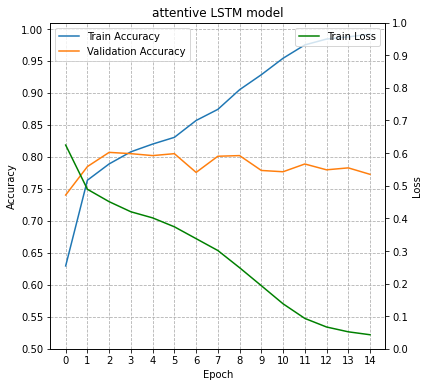

In [ ]:
train_losses, train_accuracies, test_accuracies = train_result_en
plot_network_learning("attentive LSTM model", train_accuracies, test_accuracies, train_losses)

## Finnish

In [ ]:
# Setup Model
tok2vec = compress_fasttext.models.CompressedFastTextKeyedVectors.load("../resources/fasttext-fi-mini")
pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())

model = BiLSTM_Network(pretrained_embeddings)
model.to(device)

print(model)

BiLSTM_Network(
  (embedding): Embedding(20002, 300, padding_idx=20001)
  (biLSTM): LSTM(300, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=400, out_features=2, bias=True)
)


In [ ]:
train_result_fi = train(model, tok2vec, train_fi, validation_fi)

epoch=1/10 | loss=0.58, accuracy=0.40: 100%|██████████| 215/215 [00:07<00:00, 26.90it/s]


epoch=1/10 | loss=0.57, train_accuracy=0.68, test_accuracy=0.73


epoch=2/10 | loss=0.28, accuracy=1.00: 100%|██████████| 215/215 [00:07<00:00, 27.31it/s]


epoch=2/10 | loss=0.49, train_accuracy=0.76, test_accuracy=0.75


epoch=3/10 | loss=0.14, accuracy=1.00: 100%|██████████| 215/215 [00:07<00:00, 27.19it/s]


epoch=3/10 | loss=0.45, train_accuracy=0.78, test_accuracy=0.76


epoch=4/10 | loss=0.15, accuracy=1.00: 100%|██████████| 215/215 [00:07<00:00, 27.14it/s]


epoch=4/10 | loss=0.44, train_accuracy=0.79, test_accuracy=0.77


epoch=5/10 | loss=0.25, accuracy=0.80: 100%|██████████| 215/215 [00:07<00:00, 27.42it/s]


epoch=5/10 | loss=0.43, train_accuracy=0.79, test_accuracy=0.78


epoch=6/10 | loss=0.35, accuracy=0.80: 100%|██████████| 215/215 [00:07<00:00, 27.64it/s]


epoch=6/10 | loss=0.41, train_accuracy=0.81, test_accuracy=0.77


epoch=7/10 | loss=0.11, accuracy=1.00: 100%|██████████| 215/215 [00:07<00:00, 27.39it/s]


epoch=7/10 | loss=0.40, train_accuracy=0.82, test_accuracy=0.77


epoch=8/10 | loss=0.91, accuracy=0.40: 100%|██████████| 215/215 [00:07<00:00, 27.38it/s]


epoch=8/10 | loss=0.39, train_accuracy=0.82, test_accuracy=0.78


epoch=9/10 | loss=0.08, accuracy=1.00: 100%|██████████| 215/215 [00:08<00:00, 26.84it/s]


epoch=9/10 | loss=0.38, train_accuracy=0.83, test_accuracy=0.77


epoch=10/10 | loss=0.20, accuracy=1.00: 100%|██████████| 215/215 [00:08<00:00, 24.34it/s]


epoch=10/10 | loss=0.35, train_accuracy=0.84, test_accuracy=0.76
Finished training.


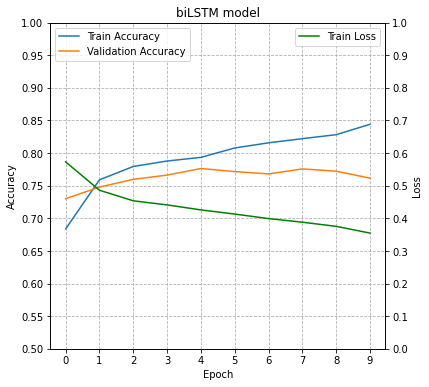

In [ ]:
train_losses, train_accuracies, test_accuracies = train_result_fi
plot_network_learning("biLSTM model", train_accuracies, test_accuracies, train_losses)

## Japanese

In [ ]:
# Setup Model
tok2vec = compress_fasttext.models.CompressedFastTextKeyedVectors.load("../resources/fasttext-ja-mini")
pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())

model = BiLSTM_Network(pretrained_embeddings)
model.to(device)

print(model)

BiLSTM_Network(
  (embedding): Embedding(20002, 300, padding_idx=20001)
  (biLSTM): LSTM(300, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=400, out_features=2, bias=True)
)


In [ ]:
train_result_ja = train(model, tok2vec, train_ja, validation_ja)

epoch=1/10 | loss=0.67, accuracy=0.60: 100%|██████████| 138/138 [00:11<00:00, 12.12it/s]


epoch=1/10 | loss=0.65, train_accuracy=0.61, test_accuracy=0.60


epoch=2/10 | loss=0.81, accuracy=0.50: 100%|██████████| 138/138 [00:11<00:00, 12.15it/s]


epoch=2/10 | loss=0.59, train_accuracy=0.68, test_accuracy=0.67


epoch=3/10 | loss=0.48, accuracy=0.90: 100%|██████████| 138/138 [00:12<00:00, 11.46it/s]


epoch=3/10 | loss=0.54, train_accuracy=0.72, test_accuracy=0.71


epoch=4/10 | loss=0.66, accuracy=0.70: 100%|██████████| 138/138 [00:11<00:00, 12.12it/s]


epoch=4/10 | loss=0.51, train_accuracy=0.75, test_accuracy=0.73


epoch=5/10 | loss=0.37, accuracy=0.80: 100%|██████████| 138/138 [00:11<00:00, 12.17it/s]


epoch=5/10 | loss=0.48, train_accuracy=0.77, test_accuracy=0.72


epoch=6/10 | loss=0.23, accuracy=0.90: 100%|██████████| 138/138 [00:11<00:00, 12.10it/s]


epoch=6/10 | loss=0.47, train_accuracy=0.78, test_accuracy=0.74


epoch=7/10 | loss=0.41, accuracy=0.70: 100%|██████████| 138/138 [00:11<00:00, 12.05it/s]


epoch=7/10 | loss=0.45, train_accuracy=0.79, test_accuracy=0.72


epoch=8/10 | loss=0.60, accuracy=0.80: 100%|██████████| 138/138 [00:11<00:00, 12.10it/s]


epoch=8/10 | loss=0.44, train_accuracy=0.80, test_accuracy=0.75


epoch=9/10 | loss=0.56, accuracy=0.80: 100%|██████████| 138/138 [00:11<00:00, 12.19it/s]


epoch=9/10 | loss=0.42, train_accuracy=0.81, test_accuracy=0.75


epoch=10/10 | loss=0.40, accuracy=0.90: 100%|██████████| 138/138 [00:11<00:00, 12.17it/s]


epoch=10/10 | loss=0.40, train_accuracy=0.82, test_accuracy=0.76
Finished training.


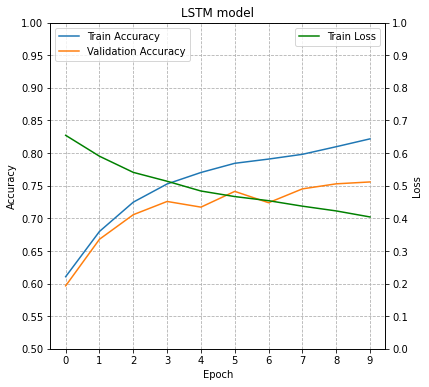

In [ ]:
train_losses, train_accuracies, test_accuracies = train_result_ja
plot_network_learning("LSTM model", train_accuracies, test_accuracies, train_losses)

## Q2A